<a href="https://colab.research.google.com/github/adamazanos/Challenge-PLATINUM-K6/blob/master/challenge_platinum_k6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. **Prepare datasets**

* *1*. cek data set train.tsv

sumber file data berdasarkan file challange ppt platinum

a. https://drive.google.com/file/d/1RCHGfn9JJyyReAh8PIIoF8Ch0H3miP0u/view

file ini diganti format txt menjadi tsv

2. cek data set abusive twiter abusive

sumber file data untuk yang diklasifikasi berdasarkan file challange ppt platinum

b. https://drive.google.com/drive/folders/1qm50pKAnzGGw9gtk--lmwR758aZOVish



---

Kesemua file di upload ulang ke github = https://github.com/adamazanos/Challenge-PLATINUM-K6 
dan menggunakan url rawnya, karena merepotkan jika harus sering mengkonek ulang sumber datanya

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

Cek data train

In [ ]:
import pandas as pd

data_train = 'https://raw.githubusercontent.com/adamazanos/Challenge-PLATINUM-K6/master/training_model/train_preprocess.tsv'

df_train = pd.read_table(data_train, header=None, names=["Text","Label"] , encoding='latin-1')


In [ ]:
df_train.head()

,Text,Label
0,warung ini dimiliki oleh pengusaha pabrik tahu...,positive
1,mohon ulama lurus dan k212 mmbri hujjah partai...,neutral
2,lokasi strategis di jalan sumatera bandung . t...,positive
3,betapa bahagia nya diri ini saat unboxing pake...,positive
4,duh . jadi mahasiswa jangan sombong dong . kas...,negative


In [ ]:
df_train.shape

(11000, 2)

In [ ]:
df_train.Label.value_counts()

positive    6416
negative    3436
neutral     1148
Name: Label, dtype: int64

Kita cek isi dataset challangenya nya dan di dalamnya terdapat 
1100 data. Terdiri dari:
*   positive    6416
*   negative    3436
*   neutral     1148








#2. Data Prepocessing

## **Text Normalization/Cleansing**

Demi kemudahan, variable nya kita pakai sesuai template

In [ ]:
import pandas as pd
import re

df_slang = pd.read_csv(r"https://raw.githubusercontent.com/adamazanos/Challenge-PLATINUM-K6/master/twitter_abuse/new_kamusalay.csv", encoding='latin=1', header=None)
df_slang = df_slang.rename(columns={0: 'slang', 1: 'formal'})

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
list_stopwords = set(stopwords.words('indonesian'))

def data_cleaning (tweet):
    #Replace enter
    c1 = re.sub ('\\n','', tweet)
    #Replace RT tag in tweet
    c2 = re.sub ('RT',' ', c1)
    #Replace mention username in tweet
    c3 = re.sub ('USER', ' ', c2)
    #Replace URL (http:// or https://) in tweet
    c4 = re.sub ('(http|https):\/\/s+', ' ', c3)
    #Replace punctuation
    c5 = re.sub ('[^0-9a-zA-Z]+', ' ', c4)
    #Replace emoticon
    c6 = re.sub ('x[a-z0-9]{2}', ' ', c5)
    #Replace Number
    c7 = re.sub ("\d+", ' ', c6)
    #Replace extra space
    c8 = re.sub ('  +', '', c7)
    return c8

def case_folding (tweet):
    return tweet.lower()

def slang_normalization(tweets):
    res = ''
    for item in tweets.split():
        if item in df_slang['slang'].values:
            res += df_slang[df_slang['slang'] == item]['formal'].iloc[0]
        else:
            res += item
        res += ' '
    return res

def stopword_removal(tweet):
    resp = ''
    for item in tweet.split():
        if item not in list_stopwords:
            resp += item
        resp +=' '
    clean = re.sub('  +', ' ', resp)
    return clean

def data_prepocessing(tweet):
    tweet = data_cleaning(tweet)
    tweet = case_folding(tweet)
    tweet = slang_normalization(tweet)
    tweet = stopword_removal(tweet)
    return tweet

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Kita test cleanernya kita beri nama cleansing

In [ ]:
df_train['text_clean'] = df_train.Text.apply(data_prepocessing)

In [ ]:
df_train.head()

,Text,Label,text_clean
0,warung ini dimiliki oleh pengusaha pabrik tahu...,positive,warung dimiliki pengusaha pabrik puluhan terke...
1,mohon ulama lurus dan k212 mmbri hujjah partai...,neutral,mohon ulama lurus kmmbri hujjah partai diwlh s...
2,lokasi strategis di jalan sumatera bandung . t...,positive,lokasi strategis jalan sumatra bandung nya nya...
3,betapa bahagia nya diri ini saat unboxing pake...,positive,betapa bahagia nya unbo paket barang nya bagus...
4,duh . jadi mahasiswa jangan sombong dong . kas...,negative,aduh mahasiswa sombong kasih kartu kuning bela...


In [ ]:
df_train.isnull().sum().sum() 

0

Sortir data berdasarkan sentimen

In [ ]:
neg = df_train.loc[df_train['Label'] == 'negative'].text_clean.tolist()
neu = df_train.loc[df_train['Label'] == 'neutral'].text_clean.tolist()
pos = df_train.loc[df_train['Label'] == 'positive'].text_clean.tolist()

neg_label = df_train.loc[df_train['Label'] == 'negative'].Label.tolist()
neu_label = df_train.loc[df_train['Label'] == 'neutral'].Label.tolist()
pos_label = df_train.loc[df_train['Label'] == 'positive'].Label.tolist()

kita test total datanya

In [ ]:
total_data = pos + neu + neg
labels = pos_label + neu_label + neg_label

print("Pos: %s, Neu: %s, Neg: %s" % (len(pos), len(neu), len(neg)))
print("Total data: %s" % len(total_data))

Pos: 6416, Neu: 1148, Neg: 3436
Total data: 11000


#3. **Feature Extraction**

In [ ]:
import pickle
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import defaultdict

max_features = 100000
tokenizer = Tokenizer(num_words=max_features, split=' ', lower=True)
tokenizer.fit_on_texts(total_data)
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
    print("tokenizer.pickle has created!")

X = tokenizer.texts_to_sequences(total_data)

vocab_size = len(tokenizer.word_index)
maxlen = max(len(x) for x in X)

X = pad_sequences(X)
with open('x_pad_sequences.pickle', 'wb') as handle:
    pickle.dump(X, handle, protocol=pickle.HIGHEST_PROTOCOL)
    print("x_pad_sequences.pickle has created!")

tokenizer.pickle has created!
x_pad_sequences.pickle has created!


In [ ]:
Y = pd.get_dummies(labels)
Y = Y.values

with open('y_labels.pickle', 'wb') as handle:
    pickle.dump(Y, handle, protocol=pickle.HIGHEST_PROTOCOL)
    print("y_labels.pickle has created!")

y_labels.pickle has created!


#  4.**Prepare train & test datasets/Splitting Dataset**

Split dataset menjadi 80% untuk train dan 20% untuk test.

In [ ]:
from sklearn.model_selection import train_test_split

file = open("x_pad_sequences.pickle",'rb')
X = pickle.load(file)
file.close()

file = open("y_labels.pickle",'rb')
Y = pickle.load(file)
file.close()

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=1)

# 5. **Penerapan Konsep Neural Network**

In [ ]:
import numpy as np
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from tensorflow.keras.layers import Flatten
from tensorflow.keras import backend as K

In [ ]:
embed_dim = 100

model_nn = Sequential()
model_nn.add(Embedding(max_features, embed_dim, input_length=maxlen))
model_nn.add(Flatten())
model_nn.add(Dense(3, activation='sigmoid'))

model_nn.compile(loss = 'binary_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model_nn.summary())

es = EarlyStopping(monitor='val_loss', mode='min',patience=3 , verbose=1)
history = model_nn.fit(X_train, y_train, epochs=10, batch_size=10, validation_data=(X_test, y_test), verbose=1, callbacks=[es])

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_13 (Embedding)    (None, 58, 100)           10000000  
                                                                 
 flatten_6 (Flatten)         (None, 5800)              0         
                                                                 
 dense_13 (Dense)            (None, 3)                 17403     
                                                                 
Total params: 10,017,403
Trainable params: 10,017,403
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
880/880 [==============================] - 91s 103ms/step - loss: 0.3408 - accuracy: 0.7653 - val_loss: 0.2603 - val_accuracy: 0.8355
Epoch 2/10
880/880 [==============================] - 91s 104ms/step - loss: 0.1606 - accuracy: 0.9106 - val_loss: 0.2486 - val_accuracy: 0.8541
Epoch 3/10

In [ ]:
from sklearn import metrics

predictions = model_nn.predict(X_test)
y_pred = predictions
matrix_test = metrics.classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1))
print("Testing selesai")
print(matrix_test)

69/69 [==============================] - 0s 2ms/step
Testing selesai
              precision    recall  f1-score   support

           0       0.77      0.78      0.77       685
           1       0.80      0.65      0.72       233
           2       0.88      0.90      0.89      1282

    accuracy                           0.84      2200
   macro avg       0.82      0.78      0.79      2200
weighted avg       0.84      0.84      0.84      2200



In [ ]:
import numpy as np
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold

kf = KFold(n_splits=5,random_state=42,shuffle=True)

accuracies = []

y = Y

embed_dim = 100

for iteration, data in enumerate(kf.split(X), start=1):

    data_train   = X[data[0]]
    target_train = y[data[0]]

    data_test    = X[data[1]]
    target_test  = y[data[1]]
    
    model_nn = Sequential()
    model_nn.add(Embedding(max_features, embed_dim, input_length=maxlen))
    model_nn.add(Flatten())
    model_nn.add(Dense(3, activation='sigmoid'))
    
    model_nn.compile(loss = 'binary_crossentropy', optimizer='adam',metrics = ['accuracy'])
  
    es = EarlyStopping(monitor='val_loss', mode='min',patience=3 , verbose=0)
    history = model_nn.fit(X_train, y_train, epochs=10, batch_size=10, validation_data=(X_test, y_test), verbose=0, callbacks=[es])

    predictions = model_nn.predict(X_test)
    y_pred = predictions

    # for the current fold only    
    accuracy = accuracy_score(y_test.argmax(axis=1), y_pred.argmax(axis=1))

    print("Training ke-", iteration)
    print(classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1)))
    print("======================================================")

    accuracies.append(accuracy)

# this is the average accuracy over all folds
average_accuracy = np.mean(accuracies)

print()
print()
print()
print("Rata-rata Accuracy: ", average_accuracy)

69/69 [==============================] - 0s 2ms/step
Training ke- 1
              precision    recall  f1-score   support

           0       0.78      0.76      0.77       685
           1       0.79      0.65      0.71       233
           2       0.87      0.91      0.89      1282

    accuracy                           0.84      2200
   macro avg       0.81      0.77      0.79      2200
weighted avg       0.84      0.84      0.84      2200

69/69 [==============================] - 0s 2ms/step
Training ke- 2
              precision    recall  f1-score   support

           0       0.77      0.78      0.78       685
           1       0.79      0.65      0.72       233
           2       0.88      0.90      0.89      1282

    accuracy                           0.84      2200
   macro avg       0.82      0.78      0.80      2200
weighted avg       0.84      0.84      0.84      2200

69/69 [==============================] - 0s 2ms/step
Training ke- 3
              precision    recall 

Hasilnya nilai rata-rata accuracy pada angka 0.8390000000000001. Ini menunjukkan model kita cukup stabil pada angka 0.83.

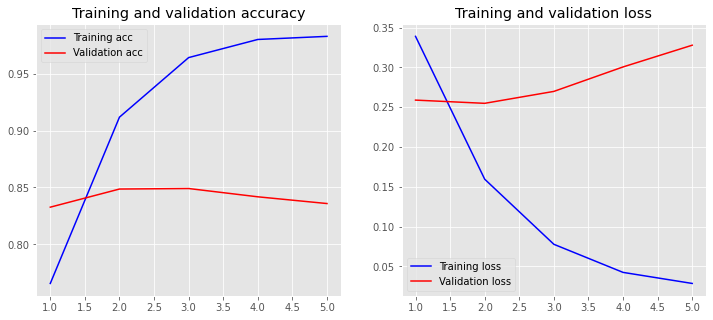

In [ ]:
# history.history
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

%matplotlib inline
plot_history(history)

In [ ]:
model_nn.save('model_nn.h5')
print("Model has created!")

Model has created!


# 6.  **Penerapan Konsep LSTM**



Jalankan training dengan metode LSTM. Arsitektur LSTM ini dibangun menggunakan framework Tensorflow.

In [ ]:
import numpy as np
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, SimpleRNN, Activation
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from tensorflow.keras.layers import Flatten
from tensorflow.keras import backend as K

Adapun arsitektur LSTM yang dibangun sebagai berikut:


*   Input Layer: Data teks setelah dilakukan Feature Extraction, dikondisikan menjadi sebuah matrix berdimensi 100. 
*   Unit Layer: Pada bagian ini diterapkan unit/neuron sejumlah 64. Pada tahap ini pula fitur Dropout diterapkan guna meminimalisir overfitting.
*   Fully-connected Layer: Setelah proses convolution, dikondisikan sebagai input untuk Multi-layer Perceptron terdiri dari 10 input dan 3 output. Pada tahap ini diimplementasikan pula aktivasi "softmax".

Untuk mencegah overfitting, kita menerapkan EarlyStopping. Sehingga, meskipun epoch belum selesai, training sudah selesai.

In [ ]:
embed_dim = 100
units = 64

model_lstm = Sequential()
model_lstm.add(Embedding(max_features, embed_dim, input_length=X.shape[1]))
model_lstm.add(LSTM(units, dropout=0.2))
model_lstm.add(Dense(3,activation='softmax'))

adam = optimizers.Adam(lr = 0.001)
model_lstm.compile(loss = 'categorical_crossentropy', optimizer = adam, metrics = ['accuracy'])
print(model_lstm.summary())

es = EarlyStopping(monitor='val_loss', mode='min', patience=3 , verbose=1)
history = model_lstm.fit(X_train, y_train, epochs=10, batch_size=10, validation_data=(X_test, y_test), verbose=1, callbacks=[es])

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 58, 100)           10000000  
                                                                 
 lstm_1 (LSTM)               (None, 64)                42240     
                                                                 
 dense_7 (Dense)             (None, 3)                 195       
                                                                 
Total params: 10,042,435
Trainable params: 10,042,435
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10


/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


880/880 [==============================] - 117s 130ms/step - loss: 0.4890 - accuracy: 0.8045 - val_loss: 0.4299 - val_accuracy: 0.8386
Epoch 2/10
880/880 [==============================] - 112s 127ms/step - loss: 0.2338 - accuracy: 0.9123 - val_loss: 0.4355 - val_accuracy: 0.8395
Epoch 3/10
880/880 [==============================] - 115s 130ms/step - loss: 0.1260 - accuracy: 0.9518 - val_loss: 0.4939 - val_accuracy: 0.8409
Epoch 4/10
880/880 [==============================] - 115s 131ms/step - loss: 0.0766 - accuracy: 0.9691 - val_loss: 0.5948 - val_accuracy: 0.8314
Epoch 4: early stopping


## Confussion Matrix, Accuracy, F1, Recall, Precision

Langkah selanjutnya adalah "Evaluation". Module "classification_report" dari Sklearn merupakan salah satu modul untuk melakukan "Evaluation". Pada tahap evaluasi ini kita akan menerapkan metode evaluasi Accuracy, Precision, Recall dan F1-Score.

In [ ]:
from sklearn import metrics

predictions = model_lstm.predict(X_test)
y_pred = predictions
matrix_test = metrics.classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1))
print("Testing selesai")
print(matrix_test)

69/69 [==============================] - 1s 12ms/step
Testing selesai
              precision    recall  f1-score   support

           0       0.75      0.79      0.77       685
           1       0.78      0.70      0.74       233
           2       0.89      0.88      0.88      1282

    accuracy                           0.83      2200
   macro avg       0.80      0.79      0.80      2200
weighted avg       0.83      0.83      0.83      2200



Hasilnya nilai F1 Score ada pada angka 0.83 untuk Negative, **??** untuk Neutral, dan 0.91 untuk Positive. Hasil ini bisa dikatakan cukup bagus untuk sebuah model, namun kecenderungan untuk memilih sentimen netralnya lemah.

## Cross Validation

In [ ]:
# Untuk lebih menyakinkan lagi, kita juga bisa melakukan "Cross Validation"
import numpy as np
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold

kf = KFold(n_splits=5,random_state=42,shuffle=True)

accuracies = []

y = Y

embed_dim = 100
units = 64

for iteration, data in enumerate(kf.split(X), start=1):

    data_train   = X[data[0]]
    target_train = y[data[0]]

    data_test    = X[data[1]]
    target_test  = y[data[1]]


    model_lstm = Sequential()
    model_lstm.add(Embedding(max_features, embed_dim, input_length=X.shape[1]))
    model_lstm.add(LSTM(units, dropout=0.2))
    model_lstm.add(Dense(3,activation='softmax'))

    adam = optimizers.Adam(lr = 0.001)
    model_lstm.compile(loss = 'categorical_crossentropy', optimizer = adam, metrics = ['accuracy'])

    es = EarlyStopping(monitor='val_loss', mode='min',patience=3 , verbose=0)
    history = model_lstm.fit(X_train, y_train, epochs=10, batch_size=10, validation_data=(X_test, y_test), verbose=0, callbacks=[es])

    predictions = model_lstm.predict(X_test)
    y_pred = predictions

    # for the current fold only    
    accuracy = accuracy_score(y_test.argmax(axis=1), y_pred.argmax(axis=1))

    print("Training ke-", iteration)
    print(classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1)))
    print("======================================================")

    accuracies.append(accuracy)

# this is the average accuracy over all folds
average_accuracy = np.mean(accuracies)

print()
print()
print()
print("Rata-rata Accuracy: ", average_accuracy)

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


69/69 [==============================] - 1s 12ms/step
Training ke- 1
              precision    recall  f1-score   support

           0       0.80      0.70      0.75       685
           1       0.73      0.77      0.75       233
           2       0.87      0.91      0.89      1282

    accuracy                           0.83      2200
   macro avg       0.80      0.80      0.80      2200
weighted avg       0.83      0.83      0.83      2200



/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


69/69 [==============================] - 1s 12ms/step
Training ke- 2
              precision    recall  f1-score   support

           0       0.76      0.76      0.76       685
           1       0.75      0.69      0.72       233
           2       0.88      0.89      0.88      1282

    accuracy                           0.83      2200
   macro avg       0.80      0.78      0.79      2200
weighted avg       0.83      0.83      0.83      2200



/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


69/69 [==============================] - 1s 12ms/step
Training ke- 3
              precision    recall  f1-score   support

           0       0.79      0.77      0.78       685
           1       0.76      0.77      0.77       233
           2       0.89      0.90      0.90      1282

    accuracy                           0.85      2200
   macro avg       0.81      0.81      0.81      2200
weighted avg       0.84      0.85      0.85      2200



/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


69/69 [==============================] - 1s 13ms/step
Training ke- 4
              precision    recall  f1-score   support

           0       0.76      0.72      0.74       685
           1       0.73      0.77      0.75       233
           2       0.87      0.89      0.88      1282

    accuracy                           0.82      2200
   macro avg       0.79      0.79      0.79      2200
weighted avg       0.82      0.82      0.82      2200



/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


69/69 [==============================] - 1s 12ms/step
Training ke- 5
              precision    recall  f1-score   support

           0       0.77      0.79      0.78       685
           1       0.76      0.71      0.73       233
           2       0.89      0.89      0.89      1282

    accuracy                           0.84      2200
   macro avg       0.81      0.80      0.80      2200
weighted avg       0.84      0.84      0.84      2200




Rata-rata Accuracy:  0.8335454545454546


Hasilnya nilai rata-rata accuracy pada angka 0.8335454545454546. Ini menunjukkan model kita cukup stabil pada angka 0.83.

## Visualization LSTM

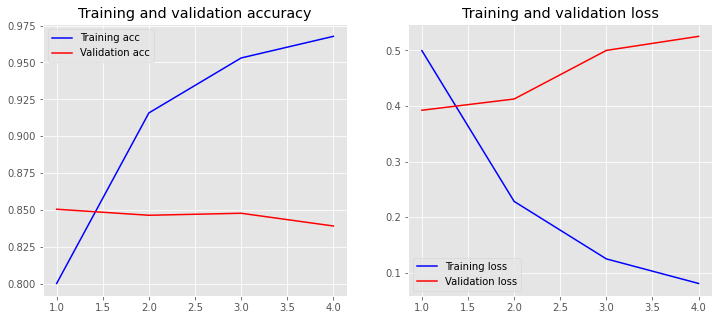

In [ ]:
# history.history
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

%matplotlib inline
plot_history(history)

Hasilnya jika kita melihat visualisasinya model yang kita kembangkan tergolong Underfitting. Disinyalir karena:


*   Data training terlalu sedikit
*   Proses training berhenti terlalu cepat. Mungkin saja penerapan EarlyStopping untuk kasus kita tidak terlalu tepat


In [ ]:
model_lstm.save('model_lstm.h5')
print("Model has created!")

Model has created!


# 7. **Data Tweet**

In [ ]:
data_twt = 'https://raw.githubusercontent.com/adamazanos/Challenge-PLATINUM-K6/master/twitter_abuse/data.csv'

df_tweet = pd.read_csv(data_twt, encoding='latin-1')

In [ ]:
df_predict = df_tweet[['Tweet']].copy()
df_predict.head()

,Tweet
0,- disaat semua cowok berusaha melacak perhatia...
1,RT USER: USER siapa yang telat ngasih tau elu?...
2,"41. Kadang aku berfikir, kenapa aku tetap perc..."
3,USER USER AKU ITU AKU\n\nKU TAU MATAMU SIPIT T...
4,USER USER Kaum cebong kapir udah keliatan dong...


#8.**Predict**

In [ ]:
import re 
from keras.models import load_model
import numpy as np
import pickle
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
sentiment = ['negative', 'neutral', 'positive']

def get_sent(sent):
    if sent==0:
        sent='negative'
    elif sent==1:
        sent='neutral'
    else: sent='positive'
    return sent

file_tokenizer = open('tokenizer.pickle', 'rb')
file_sequencer = open('x_pad_sequences.pickle', 'rb')
load_tokenizer = pickle.load(file_tokenizer)
load_sequencer = pickle.load(file_sequencer)
file_sequencer.close()
model_nn = load_model('model_nn.h5')
model_lstm = load_model('model_lstm.h5')

##A. Predict Neural Network

Predict Text

In [ ]:
input_text = """
syukur
"""

text = [data_prepocessing(input_text)]
feature = load_tokenizer.texts_to_sequences(text)
sequences= pad_sequences(feature, maxlen=load_sequencer.shape[1])

prediction = model_nn.predict(sequences)
get_sentiment = sentiment[np.argmax(prediction[0])]


print("Text : ",text[0])
print("Sentiment: ",get_sentiment)

1/1 [==============================] - 0s 62ms/step
Text :  syukur 
Sentiment:  positive


Predict DataFrame

In [ ]:
data_pre = df_predict['Tweet']

data_processed= []
for text in data_pre:
  text = data_prepocessing(text)
  data_processed.append(text)
    
feature = load_tokenizer.texts_to_sequences(data_processed)
sequences= pad_sequences(feature, maxlen=load_sequencer.shape[1])

prediction = model_nn.predict(sequences)
get_sentiment = np.argmax(prediction, axis=1)
get_sentiment = get_sentiment.reshape(-1,1)

get= []
for text in get_sentiment:
    sent= get_sent(text)
    get.append(sent)

412/412 [==============================] - 1s 2ms/step


In [ ]:
import seaborn as sns
sns.countplot(x='Sentiment', data=df_predict)

In [ ]:
df_predict

,Tweet,Text_Clean,Sentiment
0,- disaat semua cowok berusaha melacak perhatia...,cowok berusaha melacak perhatian gue lantas r...,negative
1,RT USER: USER siapa yang telat ngasih tau elu?...,telat tau edan sarap gue bergaul cigax jifla ...,negative
2,"41. Kadang aku berfikir, kenapa aku tetap perc...",kadang berpikir percaya tuhan jatuh berkali ka...,negative
3,USER USER AKU ITU AKU\n\nKU TAU MATAMU SIPIT T...,ku tau matamu sipit,negative
4,USER USER Kaum cebong kapir udah keliatan dong...,kaum cebong kafir dongoknya dungu haha,negative
...,...,...,...
13164,USER jangan asal ngomong ndasmu. congor lu yg ...,berbicara ndasmu congor sekateanjyng,negative
13165,USER Kasur mana enak kunyuk',kasur enak kunyuk,negative
13166,USER Hati hati bisu :( .g\n\nlagi bosan huft \...,hati hati bisu bosan duh,negative
13167,USER USER USER USER Bom yang real mudah terdet...,bom real mudah terdeteksi bom terkubur dahsyat...,negative


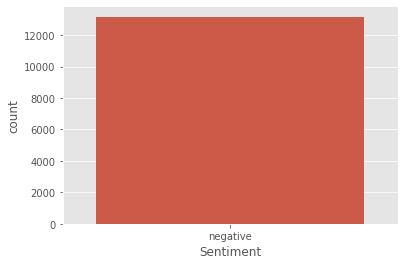

In [ ]:
import seaborn as sns
sns.countplot(x='Sentiment', data=df_predict)

## B. **Predict LSTM**

Predict Text

In [ ]:
input_text = """
syukur
"""

text = [data_prepocessing(input_text)]
feature = load_tokenizer.texts_to_sequences(text)
sequences= pad_sequences(feature, maxlen=load_sequencer.shape[1])

prediction = model_lstm.predict(sequences)
get_sentiment = sentiment[np.argmax(prediction[0])]


print("Text : ",text[0])
print("Sentiment: ",get_sentiment)

1/1 [==============================] - 0s 489ms/step
Text :  bodoh 
Sentiment:  negative


Predict DataFrame

In [ ]:
data_pre = df_predict['Tweet']

data_processed= []
for text in data_pre:
  text = data_prepocessing(text)
  data_processed.append(text)
    
feature = load_tokenizer.texts_to_sequences(data_processed)
sequences= pad_sequences(feature, maxlen=load_sequencer.shape[1])

prediction = model_lstm.predict(sequences)
get_sentiment = np.argmax(prediction, axis=1)
get_sentiment = get_sentiment.reshape(-1,1)

get= []
for text in get_sentiment:
    sent= get_sent(text)
    get.append(sent)

412/412 [==============================] - 6s 13ms/step


In [ ]:
df_predict['Text_Clean']= data_processed
df_predict['Sentiment']= get

In [ ]:
df_predict

,Tweet,Text_Clean,Sentiment
0,- disaat semua cowok berusaha melacak perhatia...,cowok berusaha melacak perhatian gue lantas r...,negative
1,RT USER: USER siapa yang telat ngasih tau elu?...,telat tau edan sarap gue bergaul cigax jifla ...,negative
2,"41. Kadang aku berfikir, kenapa aku tetap perc...",kadang berpikir percaya tuhan jatuh berkali ka...,negative
3,USER USER AKU ITU AKU\n\nKU TAU MATAMU SIPIT T...,ku tau matamu sipit,negative
4,USER USER Kaum cebong kapir udah keliatan dong...,kaum cebong kafir dongoknya dungu haha,negative
...,...,...,...
13164,USER jangan asal ngomong ndasmu. congor lu yg ...,berbicara ndasmu congor sekateanjyng,negative
13165,USER Kasur mana enak kunyuk',kasur enak kunyuk,negative
13166,USER Hati hati bisu :( .g\n\nlagi bosan huft \...,hati hati bisu bosan duh,negative
13167,USER USER USER USER Bom yang real mudah terdet...,bom real mudah terdeteksi bom terkubur dahsyat...,negative


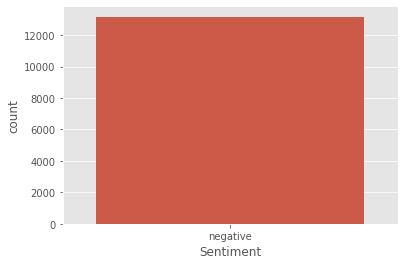

In [ ]:
import seaborn as sns
sns.countplot(x='Sentiment', data=df_predict)